In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [30]:
# Download and load the MNIST dataset
full_dataset = torchvision.datasets.MNIST(root='./data-mnist', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data-mnist', train=False, download=True, transform=transform)

100.0%
100.0%
100.0%
100.0%


In [31]:
# Split full dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [32]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [33]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Initialize the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# I like to initialize the lossess earlier so that repeated training can accumulate it
train_losses, val_losses = [], []

In [35]:
def train(epochs=10):
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        avg_val_loss = running_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

In [36]:
train(10)

Epoch [1/10], Train Loss: 0.1831, Val Loss: 0.0805
Epoch [2/10], Train Loss: 0.0510, Val Loss: 0.0548
Epoch [3/10], Train Loss: 0.0344, Val Loss: 0.0449
Epoch [4/10], Train Loss: 0.0240, Val Loss: 0.0542
Epoch [5/10], Train Loss: 0.0184, Val Loss: 0.0498
Epoch [6/10], Train Loss: 0.0154, Val Loss: 0.0496
Epoch [7/10], Train Loss: 0.0114, Val Loss: 0.0463
Epoch [8/10], Train Loss: 0.0094, Val Loss: 0.0625
Epoch [9/10], Train Loss: 0.0093, Val Loss: 0.0488
Epoch [10/10], Train Loss: 0.0084, Val Loss: 0.0485


In [37]:
# Testing loop
model.eval()
running_test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = running_test_loss / len(test_loader)
accuracy = 100 * correct / total
print(f'Accuracy on test data: {accuracy:.2f}%, Test Loss: {test_loss:.4f}')

Accuracy on test data: 99.09%, Test Loss: 0.0340


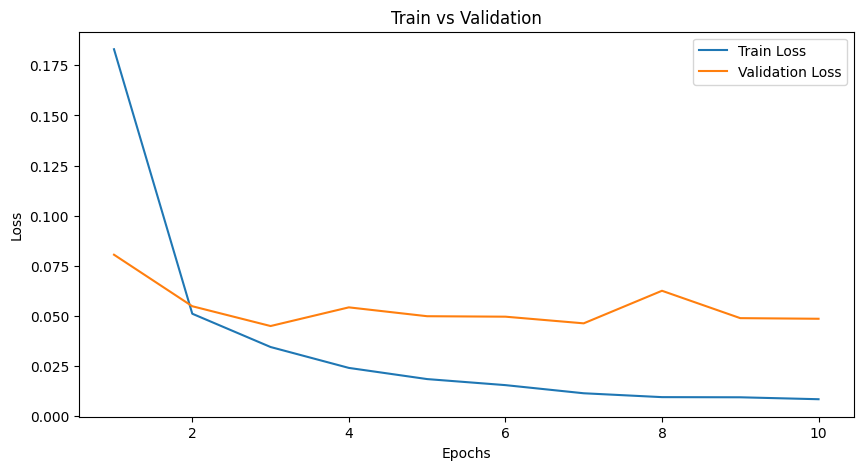

In [38]:
# Plot Train Loss vs Val Loss
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation')
plt.show()

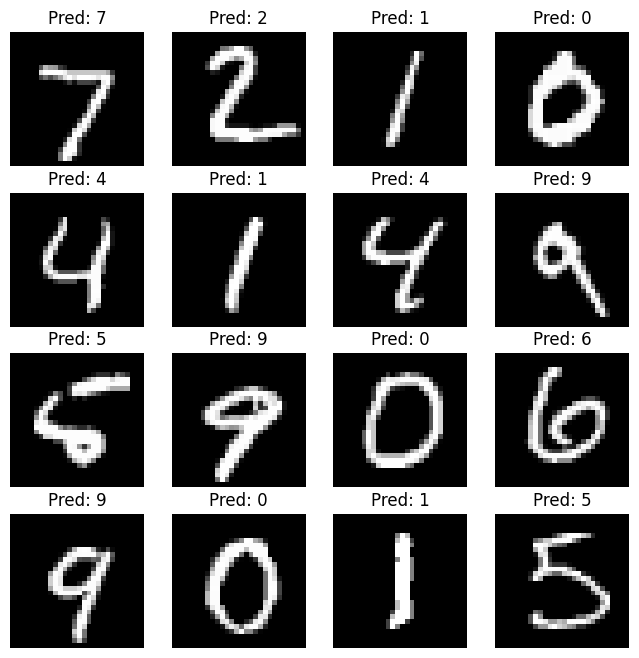

In [39]:
# Display 16 test predictions
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predictions = torch.max(outputs, 1)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.set_title(f'Pred: {predictions[i].item()}')
    ax.axis('off')

plt.show()